$$
\Huge \text{TEORIA PERKOLACJI W POŻARACH LASÓW}
$$

$$
\Large \text{Autorzy: Alicja Górnik, Ewa Herman, Julia Krempińska, Jagoda Płócienniczak}
$$

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from PIL import Image, ImageDraw
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from scipy.ndimage import label
from typing import List, Tuple
import inspect
import random

$
\huge \textbf{Prezentacja 3}
$

#### 1. Drzewa mogą znajdować się w następujących stanach, opisanych poszczególnymi kolorami:
- 0 - brak drzewa (kolor biały)
- 1 - drzewo (kolor zielony)
- 2 - palące się drzewo (kolor czerwony)
- 3 - spalone drzewo (kolor szary)

In [77]:
tree_cond = {"EMPTY": 0, "TREE": 1, "BURNING": 2, "BURNED": 3}
tree_color = {"EMPTY": "white", "TREE": "green", "BURNING": "red", "BURNED": "grey"}

#### 2. Poczatkowe parametry siatki 2D.

In [78]:
size = 50  
p_fire = 0.7  
p_tree = 0.5  

#### 3. Początkowa siatka 2D (jeszcze przed pożarem).

In [79]:
cmap = ListedColormap(tree_color.values())

In [80]:
def forest_grid(size, p_tree):
    forest = np.random.choice([tree_cond["EMPTY"], tree_cond["TREE"]], size=(size, size), p=[1-p_tree, p_tree])
    return forest

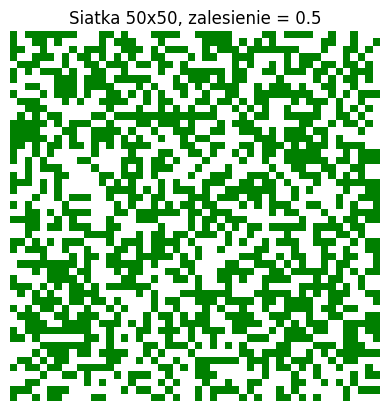

In [81]:
grid = forest_grid(size, p_tree)
plt.imshow(grid, cmap=cmap, vmin=0, vmax=3)
plt.axis('off')
plt.title(f'Siatka {size}x{size}, zalesienie = {p_tree}')
plt.show()

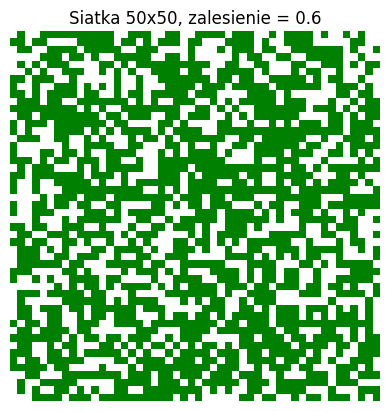

In [82]:
size = 50  
p_tree = 0.6  

grid = forest_grid(size, p_tree)
plt.imshow(grid, cmap=cmap, vmin=0, vmax=3)
plt.axis('off')
plt.title(f'Siatka {size}x{size}, zalesienie = {p_tree}')
plt.show()

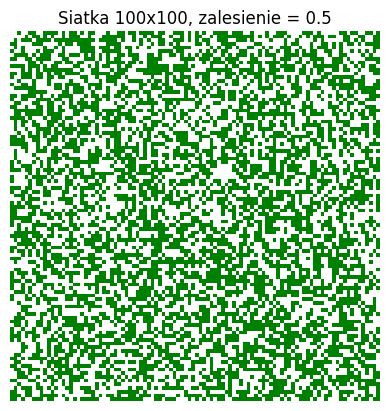

In [83]:
size = 100  
p_tree = 0.5 

grid = forest_grid(size, p_tree)
plt.imshow(grid, cmap=cmap, vmin=0, vmax=3)
plt.axis('off')
plt.title(f'Siatka {size}x{size}, zalesienie = {p_tree}')
plt.show()

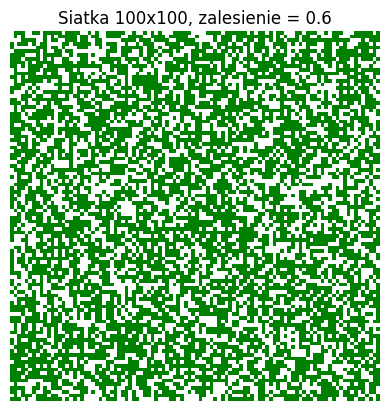

In [84]:
size = 100 
p_tree = 0.6 

grid = forest_grid(size, p_tree)
plt.imshow(grid, cmap=cmap, vmin=0, vmax=3)
plt.axis('off')
plt.title(f'Siatka {size}x{size}, zalesienie = {p_tree}')
plt.show()

#### 4. Sąsiedztwo (Von Neumanna i Moore'a)

In [85]:
def get_neighbors(x, y, size, neighborhood):
    if neighborhood == "von_neumann":
        neighbors = np.array([(x-1, y), (x+1, y), (x, y-1), (x, y+1)])
    elif neighborhood == "moore":
        neighbors = np.array([(x-1, y-1), (x-1, y), (x-1, y+1),  
                            (x, y-1), (x, y+1),             
                            (x+1, y-1), (x+1, y), (x+1, y+1)])
    else:
        return [] 
    neighbors = [(nx, ny) for nx, ny in neighbors if 0 <= nx < size and 0 <= ny < size] 
    return neighbors

#### 5. Pożar i jego rozprzestrzenianie się

In [86]:
def start_fire(forest_before_fire):
    forest = forest_before_fire.copy()
    forest[0, :] = np.where(forest[0, :] == tree_cond["TREE"], tree_cond["BURNING"], forest[0, :])
    return forest

In [87]:
def spread_fire(forest_with_fire, size, p_fire, neighborhood):
    new_forest = forest_with_fire.copy()
    size = forest_with_fire.shape[0]

    for x in range(size):
        for y in range(size):
            if forest_with_fire[x, y] == tree_cond["BURNING"]:
                new_forest[x, y] = tree_cond["BURNED"]
                
                for nx, ny in get_neighbors(x, y, size, neighborhood):
                    if forest_with_fire[nx, ny] == tree_cond["TREE"]:
                        if np.random.rand() < p_fire:
                            new_forest[nx, ny] = tree_cond["BURNING"]
    return new_forest

#### 6. Symulacja rozprzestrzeniania się ognia

In [88]:
def fire_simulation(size, p_fire, p_tree, neighborhood, gif_name, M_frames=100):
    forest = forest_grid(size, p_tree)
    frames = []

    for step in range(M_frames):
        if step == 1:
            forest = start_fire(forest)
        elif step > 1:
            forest = spread_fire(forest, forest, p_fire, neighborhood)

        fig, ax = plt.subplots(figsize=(7, 7), dpi=80)
        ax.imshow(forest, cmap=cmap, vmin=0, vmax=3)
        ax.axis('off')
        ax.set_title(f'Siatka {size}x{size}, zalesienie = {p_tree}, sąsiedztwo = {neighborhood}')
        plt.draw()
        fig.canvas.draw()

        buf = fig.canvas.buffer_rgba()
        image = Image.frombytes('RGBA', fig.canvas.get_width_height(), buf)
        frames.append(image)
        plt.close(fig)

    frames[0].save(f'{gif_name}.gif', save_all=True, append_images=frames[1:], loop=0, duration=200)
    print(f"Animacja została zapisana jako '{gif_name}.gif'")

In [89]:
# fire_simulation(size = 50, p_fire = 1, p_tree = 0.5, neighborhood="von_neumann", gif_name = f"Neumann_50x50_05", M_frames=50)

In [90]:
# fire_simulation(size = 50, p_fire = 1, p_tree = 0.6, neighborhood="von_neumann", gif_name = f"Neumann_50x50_06", M_frames=150)

In [91]:
# fire_simulation(size = 50, p_fire = 1, p_tree = 0.5, neighborhood="moore", gif_name = f"Moore_50x50_05", M_frames=100)

#### 7. Szybkość rozprzestrzeniania się pożaru.

In [92]:
def how_much_burned(size, p_fire, p_tree, neighborhood, M=100):
    burned = np.zeros(M)
    forest = forest_grid(size, p_tree)
    total_trees = np.sum(forest == tree_cond["TREE"])
    forest = start_fire(forest)
    
    for step in range(M):
        burned_trees = np.sum(forest == tree_cond["BURNED"]) + np.sum(forest == tree_cond["BURNING"])
        burned[step] = (burned_trees / total_trees) * 100 if total_trees > 0 else 0
        forest = spread_fire(forest, size, p_fire, neighborhood)

    return burned, np.arange(M)

##### 7.1. Rozprzestrzenianie się pożaru VS n-ty krok symulacji

- Przypadek jednej symulacji / jednego wyniku

In [93]:
M = 200
p_fire, p_tree = 1, 0.6
size = 50

In [94]:
# burned_neumann_v1, steps = how_much_burned(size, p_fire=p_fire, p_tree=p_tree, neighborhood="von_neumann", M=M)
# burned_moore_v1, _ = how_much_burned(size, p_fire=p_fire, p_tree=p_tree, neighborhood="moore", M=M)

In [95]:
# plt.figure(figsize=(6, 4))
# plt.plot(steps, burned_moore_v1, label="Sąsiedztwo Moore'a", color="blue")
# plt.plot(steps, burned_neumann_v1, label="Sąsiedztwo von Neumanna", color="orange")
# plt.xlabel('Krok symulacji')
# plt.ylabel('Rozmiar spalonego obszaru (%)')
# param_text = f"p_tree = {0.6}\np_fire = {1.0}\ngrid_size = {size}x{size}"
# plt.text(0.98, 0.2, param_text,
#          transform=plt.gca().transAxes,  
#          fontsize=9,
#          verticalalignment='bottom',
#          horizontalalignment='right',
#          bbox=dict(boxstyle='round', facecolor='white', edgecolor='gray', alpha=0.5))
# plt.legend(loc = "lower right")
# plt.grid(True, linestyle = '--')
# plt.tight_layout()
# #plt.savefig("burned_vs_steps.png", dpi=300)
# plt.show()

- Średnia z 100 symulacji

In [96]:
N = 100
M = 200
p_fire, p_tree = 1, 0.6
size = 50

In [97]:
# burned_neumann_v2 = np.zeros((N, M))
# burned_moore_v2 = np.zeros((N, M))
# steps = np.arange(M)

# for i in range(N):
#     burned_neumann_v2[i,:], _ = how_much_burned(size, p_fire=p_fire, p_tree=p_tree, neighborhood="von_neumann", M=M)
#     burned_moore_v2[i,:], _ = how_much_burned(size, p_fire=p_fire, p_tree=p_tree, neighborhood="moore", M=M)

# avg_burned_neumann = np.mean(burned_neumann_v2, axis=0)
# avg_burned_moore = np.mean(burned_moore_v2, axis=0)

In [98]:
# plt.figure(figsize=(6, 4))
# plt.plot(steps, avg_burned_moore, label="Sąsiedztwo Moore'a", color="blue")
# plt.plot(steps, avg_burned_neumann, label="Sąsiedztwo von Neumanna", color="orange")
# plt.xlabel('Krok symulacji')
# plt.ylabel('Średni rozmiar spalonego obszaru (%)')
# param_text = f"p_tree = {0.6}\np_fire = {1.0}\ngrid_size = {size}x{size}"
# plt.text(0.98, 0.2, param_text,
#          transform=plt.gca().transAxes,  
#          fontsize=9,
#          verticalalignment='bottom',
#          horizontalalignment='right',
#          bbox=dict(boxstyle='round', facecolor='white', edgecolor='gray', alpha=0.5))
# plt.legend(loc = "lower right")
# plt.grid(True, linestyle = '--')
# plt.tight_layout()
# #plt.savefig("avg100_burned_vs_steps.png", dpi=300)
# plt.show()

##### 7.2. Rozprzestrzenianie się pożaru VS wartość zalesienia (p_tree)

- Przypadek jednej symulacji / jednego wyniku

In [99]:
M = 200
p_fire = 1
p_tree_values = np.arange(0.1, 1.1, 0.1)
size = 50

In [100]:
# burned_neumann_v3 = np.zeros((len(p_tree_values), M))
# burned_moore_v3 = np.zeros((len(p_tree_values), M))
# steps = np.arange(M)

# for i, p_tree in enumerate(p_tree_values):
#     burned_neumann_v3[i,:], _ = how_much_burned(size, p_fire=p_fire, p_tree=p_tree, neighborhood="von_neumann", M=M)
#     burned_moore_v3[i,:], _ = how_much_burned(size, p_fire=p_fire, p_tree=p_tree, neighborhood="moore", M=M)

In [101]:
# plt.figure(figsize=(6, 4))
# plt.plot(p_tree_values, burned_moore_v3[:,-1], label="Sąsiedztwo Moore'a", color="blue")
# plt.plot(p_tree_values, burned_neumann_v3[:,-1], label="Sąsiedztwo von Neumanna", color="orange")
# plt.xlabel('Prawdopodobieństwo zalesienia (p_tree)')
# plt.ylabel('Rozmiar spalonego obszaru (%)')
# param_text = f"p_tree = {p_tree}\np_fire = {p_fire}\ngrid_size = {size}x{size}\nsim_steps = {M}"
# plt.text(0.98, 0.2, param_text,
#          transform=plt.gca().transAxes,  
#          fontsize=9,
#          verticalalignment='bottom',
#          horizontalalignment='right',
#          bbox=dict(boxstyle='round', facecolor='white', edgecolor='gray', alpha=0.5))
# plt.legend(loc = "lower right")
# plt.grid(True, linestyle = '--')
# plt.tight_layout()
# #plt.savefig("burned_vs_tree.png", dpi=300)
# plt.show()

- Średnia z 100 symulacji

In [102]:
N = 100
M = 200
p_fire = 1
p_tree_values = np.arange(0.1, 1.1, 0.1)
size = 50

In [103]:
# burned_neumann_v4 = np.zeros((len(p_tree_values), N))
# burned_moore_v4 = np.zeros((len(p_tree_values), N))

# for j in range(N):
#     for i, p_tree in enumerate(p_tree_values):
#         burned_neumann, _ = how_much_burned(size, p_fire=p_fire, p_tree=p_tree, neighborhood="von_neumann", M=M)
#         burned_moore, _ = how_much_burned(size, p_fire=p_fire, p_tree=p_tree, neighborhood="moore", M=M)

#         burned_neumann_v4[i, j] = burned_neumann[-1]
#         burned_moore_v4[i, j] = burned_moore[-1]

# avg_burned_neumann_v2 = np.mean(burned_neumann_v4, axis=1)
# avg_burned_moore_v2 = np.mean(burned_moore_v4, axis=1)

In [104]:
# plt.figure(figsize=(6, 4))
# plt.plot(p_tree_values, avg_burned_moore_v2, label="Sąsiedztwo Moore'a", color="blue")
# plt.plot(p_tree_values, avg_burned_neumann_v2, label="Sąsiedztwo von Neumanna", color="orange")
# plt.xlabel('Prawdopodobieństwo zalesienia (p_tree)')
# plt.ylabel('Średni rozmiar spalonego obszaru (%)')
# param_text = f"p_tree = {p_tree}\np_fire = {p_fire}\ngrid_size = {size}x{size}\nsim_steps = {M}"
# plt.text(0.98, 0.2, param_text,
#          transform=plt.gca().transAxes,  
#          fontsize=9,
#          verticalalignment='bottom',
#          horizontalalignment='right',
#          bbox=dict(boxstyle='round', facecolor='white', edgecolor='gray', alpha=0.5))
# plt.legend(loc = "lower right")
# plt.grid(True, linestyle = '--')
# plt.tight_layout()
# #plt.savefig("avg100_burned_vs_tree.png", dpi=300)
# plt.show()

##### 7.2. Rozprzestrzenianie się pożaru VS rozmiar siatki (size)

- Przypadek jednej symulacji / jednego wyniku

In [105]:
M = 200
p_fire, p_tree = 1, 0.6
size_values = np.arange(50, 300, 50)

In [106]:
# burned_neumann_v5 = np.zeros((len(size_values), M))
# burned_moore_v5 = np.zeros((len(size_values), M))

# for i, size in enumerate(size_values):
#     burned_neumann_v5[i,:], _ = how_much_burned(size, p_fire=p_fire, p_tree=p_tree, neighborhood="von_neumann", M=M)
#     burned_moore_v5[i,:], _ = how_much_burned(size, p_fire=p_fire, p_tree=p_tree, neighborhood="moore", M=M)

In [107]:
# plt.figure(figsize=(6, 4))
# plt.plot(size_values, burned_moore_v5[:,-1], label="Sąsiedztwo Moore'a", color="blue")
# plt.plot(size_values, burned_neumann_v5[:,-1], label="Sąsiedztwo von Neumanna", color="orange")
# plt.xlabel('Rozmiar siatki (size)')
# plt.ylabel('Rozmiar spalonego obszaru (%)')
# param_text = f"p_tree = {0.6}\np_fire = {p_fire}\nsim_steps = {M}"
# plt.text(0.23, 0.2, param_text,
#          transform=plt.gca().transAxes,  
#          fontsize=9,
#          verticalalignment='bottom',
#          horizontalalignment='right',
#          bbox=dict(boxstyle='round', facecolor='white', edgecolor='gray', alpha=0.5))
# plt.legend(loc = "lower left")
# plt.grid(True, linestyle = '--')
# plt.tight_layout()
# #plt.savefig("burned_vs_size.png", dpi=300)
# plt.show()

- Średnia z 100 symulacji

In [108]:
M = 200
N = 100
p_fire, p_tree = 1, 0.6
size_values = np.arange(50, 300, 50)

In [109]:
# burned_neumann_v6 = np.zeros((len(size_values), N))
# burned_moore_v6 = np.zeros((len(size_values), N))

# for j in range(N):
#     for i, size in enumerate(size_values):
#         burned_neumann, _ = how_much_burned(size=size, p_fire=p_fire, p_tree=p_tree, neighborhood="von_neumann", M=M)
#         burned_moore, _ = how_much_burned(size=size, p_fire=p_fire, p_tree=p_tree, neighborhood="moore", M=M)

#         burned_neumann_v6[i, j] = burned_neumann[-1]
#         burned_moore_v6[i, j] = burned_moore[-1]

# avg_burned_neumann_v3 = np.mean(burned_neumann_v6, axis=1)
# avg_burned_moore_v3 = np.mean(burned_moore_v6, axis=1)

In [110]:
# plt.figure(figsize=(6, 4))
# plt.plot(size_values, avg_burned_moore_v3, label="Sąsiedztwo Moore'a", color="blue")
# plt.plot(size_values, avg_burned_neumann_v3, label="Sąsiedztwo von Neumanna", color="orange")
# plt.xlabel('Rozmiar siatki (size)')
# plt.ylabel('Średni rozmiar spalonego obszaru (%)')
# param_text = f"p_tree = {p_tree}\np_fire = {p_fire}\nsim_steps = {M}"
# plt.text(0.23, 0.2, param_text,
#          transform=plt.gca().transAxes,  
#          fontsize=9,
#          verticalalignment='bottom',
#          horizontalalignment='right',
#          bbox=dict(boxstyle='round', facecolor='white', edgecolor='gray', alpha=0.5))
# plt.legend(loc = "lower left")
# plt.grid(True, linestyle = '--')
# plt.tight_layout()
# #plt.savefig("avg100_burned_vs_size.png", dpi=300)
# plt.show()

$
\huge \textbf{Prezentacja 4}
$

#### 1. Funkcje start_fire

- zapalamy pierwszy rząd siatki

In [111]:
def start_fire_1st_row(forest_before_fire):
    forest = forest_before_fire.copy()
    forest[0, :] = np.where(forest[0, :] == tree_cond["TREE"], tree_cond["BURNING"], forest[0, :])
    return forest

- zapalamy losowe drzewo w największym klastrze:

In [112]:
def find_largest_cluster(forest, neighborhood):
    structure = np.array([[0,1,0],[1,1,1],[0,1,0]]) if neighborhood == "von_neumann" else np.ones((3,3), int)
    tree_mask = (forest == tree_cond["TREE"])
    labeled, num_features = label(tree_mask, structure=structure)

    largest_size = 0
    largest_cluster = 0
    for i in range(1, num_features+1):
        size = np.sum(labeled == i)
        if size > largest_size:
            largest_size = size
            largest_cluster = i

    coords = np.argwhere(labeled == largest_cluster)
    return coords

In [113]:
def start_fire_claster(forest_before_fire, neighborhood="moore", mode="largest_single"):
    forest = forest_before_fire.copy()
    largest_cluster_coords = find_largest_cluster(forest, neighborhood)

    x, y = random.choice(largest_cluster_coords)
    forest[x, y] = tree_cond["BURNING"]

    return forest

#### 2. Las nie jest jednolity - mogą występować różne rodzaje drzew co wpływa na łatwość ich zapalenia (p_fire). Na ten moment rozważamy najprosztszą sytuację:
- 1 - drzewo łatwopalne (kolor jasnozielony)
- 2 - drzewo trudnopalne (kolor ciemnozielony)

In [127]:
tree_type = {"EMPTY": 0, "Łatwopalne": 1, "Trudnopalne": 2}
tree_type_color = {"EMPTY": "white", "Łatwopalne": "yellowgreen", "Trudnopalne": "green"}
p_fire_mixed = {"Łatwopalne": 1, "Trudnopalne": 0}
burning_time = {"Łatwopalne": 3, "Trudnopalne": 10}

In [128]:
def mixed_forest_grid(size: int, p_tree: float, tree_types: List[int] = None, tree_ratio: List[float] = [0.3, 0.7]) -> Tuple[np.ndarray, np.ndarray]:
    if tree_types is None:
        tree_types = list(tree_type.values())
    tree_ratio = np.array(tree_ratio) * p_tree

    mixed_forest = np.random.choice(tree_types, size=(size,size), p=[1 - p_tree, *tree_ratio])
    forest = np.where(mixed_forest != tree_type["EMPTY"], tree_cond["TREE"], tree_cond["EMPTY"])

    return forest, mixed_forest

##### 2.1. Siatka lasu z różnymi typami drzew

In [ ]:
def draw_mixed_forest(size, tree_ratio, colors, tree_types=None, p_tree=0.6):
    if tree_types is None:
        tree_types = list(tree_type.values())
    legend_labels=list(tree_type.keys())[1:]

    _, mixed_grid = mixed_forest_grid(size=size, p_tree=p_tree, tree_types=tree_types, tree_ratio=tree_ratio)
    cmap = ListedColormap(colors.values())
    vmin, vmax = 0, len(list(colors.keys()))-1

    plt.figure(figsize=(6,4))
    ax = plt.gca()
    ax.imshow(mixed_grid, cmap=cmap, vmin=vmin, vmax=vmax)

    for spine in ax.spines.values():
        spine.set_linewidth(1)
        spine.set_color('black')

    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    plt.title(f'zalesienie = {p_tree}, tree_ratio = {tree_ratio}')

    legend_elements = [mpatches.Patch(color=colors[label], label=label) for label in legend_labels]
    plt.legend(handles=legend_elements, loc="upper right", bbox_to_anchor=(1.6, 1.0), title="Rodzaje drzew: ")
    
    plt.show()

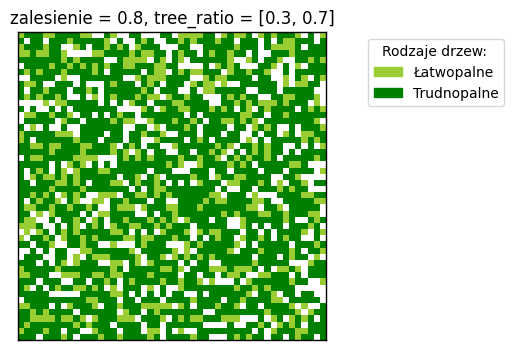

In [130]:
size = 50
p_tree = 0.8
ratio =[0.3, 0.7]

draw_mixed_forest(size=size, tree_ratio=ratio, colors=tree_type_color, p_tree=p_tree)

##### 2.2. Rozprzestrzenianie się pożaru w lesie z różnymi typami drzew

In [131]:
def spread_fire_mixed(forest_with_fire, mixed_forest, p_fire_mixed, neighborhood, burning_time, burning_time_dict):
    size = forest_with_fire.shape[0]
    new_forest = forest_with_fire.copy()
    new_burning_time = burning_time.copy()

    id_to_name = {v: k for k, v in tree_type.items()}

    for x in range(size):
        for y in range(size):
            if forest_with_fire[x, y] == tree_cond["BURNING"]:
                new_burning_time[x, y] += 1
                tree_name = id_to_name.get(mixed_forest[x, y], "EMPTY")

                if new_burning_time[x, y] >= burning_time_dict.get(tree_name, float('inf')):
                    new_forest[x, y] = tree_cond["BURNED"]

                for nx, ny in get_neighbors(x, y, size, neighborhood):
                    if forest_with_fire[nx, ny] == tree_cond["TREE"]:
                        neighbor_name = id_to_name.get(mixed_forest[nx, ny], "EMPTY")
                        p_fire = p_fire_mixed.get(neighbor_name, 0)
                        if np.random.rand() < p_fire:
                            new_forest[nx, ny] = tree_cond["BURNING"]
                            new_burning_time[nx, ny] = 0

    return new_forest, new_burning_time

In [132]:
# def get_colored_forest(forest, forest_type):
#     size = forest.shape[0]
#     rgb_array = np.zeros((size, size, 3), dtype=np.uint8)

#     for x in range(size):
#         for y in range(size):
#             cell = forest[x, y]
#             if cell == tree_cond["TREE"]:
#                 t_type = forest_type[x, y]
#                 color_name = tree_type_color.get(t_type, "green")
#             else:
#                 color_name = tree_color.get(cell, "white")

#             rgb = np.array(mcolors.to_rgb(color_name)) * 255
#             rgb_array[x, y] = rgb.astype(np.uint8)
#     return rgb_array

In [133]:
def get_colored_forest(forest, mixed_forest):
    size = forest.shape[0]
    rgb_array = np.zeros((size, size, 3), dtype=np.uint8)

    inverse_tree_type = {v: k for k, v in tree_type.items()}

    for x in range(size):
        for y in range(size):
            cell = forest[x, y]

            if cell == tree_cond["TREE"]:
                t_type_value = mixed_forest[x, y]
                t_type_name = inverse_tree_type.get(t_type_value, "EMPTY")
                color_name = tree_type_color.get(t_type_name, "green")
            else:
                t_cond_name = [k for k, v in tree_cond.items() if v == cell][0]
                color_name = tree_color.get(t_cond_name, "white")

            rgb = np.array(mcolors.to_rgb(color_name)) * 255
            rgb_array[x, y] = rgb.astype(np.uint8)

    return rgb_array

In [134]:
def fire_simulation_mixed(size, p_tree, tree_ratio, p_fire_mixed, neighborhood, burning_time_dict, 
                          start_fire_func=start_fire_1st_row, gif_name='fire', save=False, M_frames=100):
    
    forest, mixed_forest = mixed_forest_grid(size, p_tree, tree_ratio=tree_ratio)
    burning_time = np.zeros_like(forest, dtype=int)
    frames = []

    legend_elements = [mpatches.Patch(color=tree_type_color[label], label=label)
                       for label in tree_type][1:]

    sig = inspect.signature(start_fire_func)
    required_params = sig.parameters.keys()
    
    start_fire_kwargs = {}
    if 'forest_before_fire' in required_params:
        start_fire_kwargs['forest_before_fire'] = forest
    if 'neighborhood' in required_params:
        start_fire_kwargs['neighborhood'] = neighborhood

    for step in range(M_frames):
        if step == 1:
            forest = start_fire_func(**start_fire_kwargs)
        elif step > 1:
            forest, burning_time = spread_fire_mixed(forest, mixed_forest, p_fire_mixed, neighborhood, burning_time, burning_time_dict)

        fig, ax = plt.subplots(figsize=(7, 7), dpi=80)
        colored_forest = get_colored_forest(forest, mixed_forest)
        ax.imshow(colored_forest)
        ax.axis('off')
        ax.set_title(f'Siatka {size}x{size}, zalesienie = {p_tree}, sąsiedztwo = {neighborhood}')
        ax.legend(handles=legend_elements, loc="lower left", title_fontsize=14, fontsize=12, borderpad=1.0,
                  bbox_to_anchor=(-0.1, -0.1), title="Rodzaje drzew")
        plt.draw()
        fig.canvas.draw()

        buf = fig.canvas.buffer_rgba()
        image = Image.frombytes('RGBA', fig.canvas.get_width_height(), buf)
        frames.append(image)
        plt.close(fig)
        
    if save:
        frames[0].save(f'{gif_name}.gif', save_all=True, append_images=frames[1:], loop=0, duration=200)
        print(f"Animacja została zapisana jako '{gif_name}.gif'")


In [135]:
p_fire_mixed = {"Łatwopalne": 0.8, "Trudnopalne": 0.3}
size=50
p_tree=0.6
tree_ratio = [0.5, 0.5]
neighborhood = 'moore'

# start_fire = 1st row
fire_simulation_mixed(size, p_tree, tree_ratio, p_fire_mixed, neighborhood, {"Łatwopalne": 1, "Trudnopalne":1}, 
                      start_fire_func=start_fire_1st_row, gif_name = 'moore_tr5050_pf08-03_bt1-1_f1st', save=True)

# start_fire = claster
fire_simulation_mixed(size, p_tree, tree_ratio, p_fire_mixed, neighborhood, {"Łatwopalne": 3, "Trudnopalne":6}, 
                      start_fire_func=start_fire_claster, gif_name = 'moore_tr5050_pf08-03_bt3-6_claster', save=True)


Animacja została zapisana jako 'moore_tr5050_pf08-03_bt1-1_f1st.gif'
Animacja została zapisana jako 'moore_tr5050_pf08-03_bt3-6_claster.gif'


##### 2.3. Rozmiar spalonego obszaru (wyodrębnienie typów drzew)

In [ ]:
def how_much_burned_mixed(size, p_fire_mixed, tree_ratio, p_tree, neighborhood, 
                          burning_time_dict, start_fire_func = start_fire_1st_row, tree_types=None, M=100):
    burned_all = np.zeros(M)
    burned_easy = np.zeros(M)
    burned_hard = np.zeros(M)

    forest, mixed_forest = mixed_forest_grid(size=size, p_tree=p_tree, tree_types=tree_types, tree_ratio=tree_ratio)
    burning_time = np.zeros_like(forest, dtype=int)
    total_trees = np.sum(forest == tree_cond["TREE"])

    sig = inspect.signature(start_fire_func)
    required_params = sig.parameters.keys()
    
    start_fire_kwargs = {}
    if 'forest_before_fire' in required_params:
        start_fire_kwargs['forest_before_fire'] = forest
    if 'neighborhood' in required_params:
        start_fire_kwargs['neighborhood'] = neighborhood

    forest = start_fire_func(**start_fire_kwargs)
    
    for step in range(M):
        burning_mask = (forest == tree_cond["BURNED"]) | (forest == tree_cond["BURNING"])
        burned_trees = np.sum(burning_mask)
        
        burned_easy_count = np.sum(burning_mask & (mixed_forest == tree_type["Łatwopalne"]))
        burned_hard_count = np.sum(burning_mask & (mixed_forest == tree_type["Trudnopalne"]))
        
        burned_all[step] = (burned_trees / total_trees) * 100 if total_trees > 0 else 0
        burned_easy[step] = (burned_easy_count / total_trees) * 100 if total_trees > 0 else 0
        burned_hard[step] = (burned_hard_count / total_trees) * 100 if total_trees > 0 else 0
        
        forest, burning_time = spread_fire_mixed(forest, mixed_forest, p_fire_mixed, neighborhood, burning_time, burning_time_dict)
    
    return burned_all, burned_easy, burned_hard

In [138]:
def bar_plots(size, M, p_fire_mixed, tree_ratio, p_tree, neighborhood, burning_time_dict, start_fire_func = start_fire_1st_row,
              save_name='bars', save=False, tree_types=None, step=20, width=2, xs=2, legend_loc="lower right"):
    
    M_range = np.arange(M)
    
    burned_all, burned_easy, burned_hard = how_much_burned_mixed(
        size=size, 
        p_fire_mixed=p_fire_mixed, 
        tree_ratio=tree_ratio, 
        p_tree=p_tree, 
        neighborhood=neighborhood, 
        burning_time_dict = burning_time_dict,
        start_fire_func = start_fire_func,
        tree_types=tree_types, 
        M=M
    )

    M_range_thinned = M_range[::step]
    burned_all_thinned = burned_all[::step]
    burned_easy_thinned = burned_easy[::step]
    burned_hard_thinned = burned_hard[::step]

    plt.figure(figsize=(6, 4))

    plt.bar(M_range_thinned - xs, burned_all_thinned, width=width, label='Wszystkie spalone drzewa')
    plt.bar(M_range_thinned, burned_easy_thinned, width=width, label=f'Łatwopalne drzewa')
    plt.bar(M_range_thinned + xs, burned_hard_thinned, width=width, label=f'Trudnopalne drzew')

    plt.xlabel('Krok czasowy')
    plt.ylabel('Procent spalonych drzew (%)')

    param_text = f"grid_size = {size}x{size}\np_tree = {p_tree}\ntree_ratio = {tree_ratio}\np_fire={list(p_fire_mixed.values())}\nburning_time={list(burning_time_dict.values())}"
    plt.text(0.03, 0.72, param_text,
             transform=plt.gca().transAxes,
             fontsize=9,
             verticalalignment='bottom',
             horizontalalignment='left',
             bbox=dict(boxstyle='round', facecolor='white', edgecolor='gray', alpha=0.85))

    plt.legend(loc=legend_loc)
    title_text = f'Wykres dla sąsiedztwa {neighborhood.capitalize()}\nWybuch pożaru: {start_fire_func.__name__}'

    plt.title(title_text)
    plt.grid(True, linestyle='--')
    plt.tight_layout()

    if save:
        plt.savefig(f"{save_name}.png", dpi=300)
    plt.show()

a) 
- tree_ratio = [0.5, 0.5]: 

-> Łatwopalne: p_fire = 1, burning_time = 1; 

-> Trudnopalne: p_fire = 0.3, burning_time = 1;

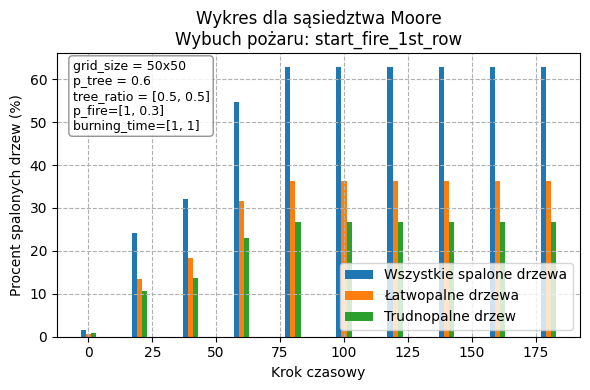

In [139]:
bar_plots(
    size=50,
    M=200,
    p_fire_mixed={"Łatwopalne": 1, "Trudnopalne": 0.3},
    tree_ratio=[0.5, 0.5],
    p_tree=0.6,
    neighborhood='moore',
    burning_time_dict = {"Łatwopalne": 1, "Trudnopalne": 1},
    start_fire_func=start_fire_1st_row,
    save=False,
    save_name="bb_tr5050_pf1-03_bt1-1_f1st_r.png"
)
